In [138]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

In [139]:
# load data and make its utils
data = load_iris()
shuffledIndices = np.random.permutation(len(data.target))
data.data, data.target = data.data[shuffledIndices], data.target[shuffledIndices]
iris_name = ['setosa', 'versicolour', 'virginica']

[dataset specification](https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_iris.html)
### Predict type of Iris by given Features
**class**: [setosa, versicolour, virginica]
**Number of Instances**: 150 (50 in each of three classes)
**Number of Attributes**: 4 numeric, predictive attributes and the class
**Attribute Information**:
* sepal length in cm
* sepal width in cm
* petal length in cm
* petal width in cm

In [140]:
# represent the data using pandas
df = pd.DataFrame(data.data, columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'], index=[iris_name[_] for _ in data.target])
df.sample(n=8)

,Sepal Length,Sepal Width,Petal Length,Petal Width
virginica,5.8,2.7,5.1,1.9
virginica,7.4,2.8,6.1,1.9
versicolour,5.5,2.4,3.8,1.1
virginica,7.3,2.9,6.3,1.8
setosa,4.8,3.4,1.6,0.2
virginica,5.8,2.8,5.1,2.4
versicolour,6.1,2.8,4.0,1.3
virginica,6.7,3.0,5.2,2.3


In [141]:
# define Dataset
class Dataset:
    def __init__(self, dataset):
      self.x, self.y = dataset
    def __getitem__(self, item): return self.x[item], self.y[item]
    def __len__(self): return len(self.y)
# Dataset

# init Datasets
trainset = Dataset((data.data, data.target))
testset = Dataset((data.data, data.target))

### Loss Functions: MSE and MAE

Loss functions are a critical component in machine learning models, particularly for regression tasks. They quantify the difference between the predicted values and the actual target values, guiding the optimization process to minimize this error.

#### Mean Squared Error (MSE)
MSE calculates the average of the squared differences between the predicted and actual values. It is defined as:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

- **Penalizes larger errors more heavily**: Squaring the errors makes MSE more sensitive to outliers.
- **Continuous optimization**: Smooth gradients make it suitable for many gradient-based optimization algorithms.
- **Use Case**: Ideal when large errors need to be penalized significantly.

### Mean Absolute Error (MAE)
MAE calculates the average of the absolute differences between the predicted and actual values. It is defined as:
$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

- **Treats all errors equally**: MAE is less sensitive to outliers compared to MSE.
- **Robust to Outliers**: Does not disproportionately penalize larger deviations.
- **Use Case**: Ideal for datasets where outliers are present and need to be treated equally.

In [142]:
# define loss functions(MSE, MAE)
def mean_squared_error(independent, dependent, weight):
    probability = np.dot(independent, weight)
    return np.mean((probability - dependent) ** 2)
# mean_squared_error

def mean_absolute_error(independent, dependent, weight):
    probability = np.dot(independent, weight)
    return np.mean(abs(probability - dependent))
# mean_absolute_error

### Gradient Descent with Regularization (GDR)
Gradient Descent with Regularization (GDR) is an optimization technique used to minimize the loss function while controlling the complexity of the model. By incorporating regularization terms into the loss function, GDR helps to prevent overfitting and improves the generalization of the model to unseen data. Update rule:
$$\theta = \theta - \eta \cdot \nabla L(\theta)$$
Gradient Descent is an iterative optimization algorithm used to minimize the loss function by updating model parameters in the direction of the steepest descent of the gradient.

In [143]:
# define LinearRegression
class LinearRegression:
    def __init__(self, n_inpt): self.weight = np.zeros(shape=(n_inpt))
    
    def gdr(self, x, y, lr):
      indications = self.__call__(x)
      self.weight -= (lr / x.shape[0]) * np.dot(x.T, (indications - y))
    # gdr
    
    def train(self, dataset, iters: int, lr=0.01):
        for _ in range(iters):
            for x, y in dataset:
                self.gdr(x, y, lr=lr)
    # train

    def __call__(self, x):
      pred = np.dot(x, self.weight)
      return pred if pred <= 2 else 2

    def loss(self, dataset, optimizer=mean_squared_error):
        x, y = dataset.x, dataset.y
        loss = optimizer(x, y, self.weight)
        print(f"loss: {loss:.3f}")
    # loss
# LogisticRegression

In [144]:
# init and train a model
model = LinearRegression(len(trainset.x[0]))
model.loss(trainset, optimizer=mean_squared_error)
model.train(trainset, iters=1000, lr=0.01)
model.loss(testset, optimizer=mean_squared_error)

loss: 1.667
loss: 0.056


### Ordinal Linear Regression
[wikipedia](https://en.wikipedia.org/wiki/Ordinal_regression)
Ordinal Linear Regression is a statistical model used to predict an ordinal variable based on a given feature vector. The model outputs a continuous value (a float) within specific ranges corresponding to the ordinal categories. These predicted values are then mapped to discrete ordinal labels to classify instances appropriately.
* **around 0 or below:** represents setosa
* **around 1:** represents versicolour
* **around 3 or above:** represents virginica

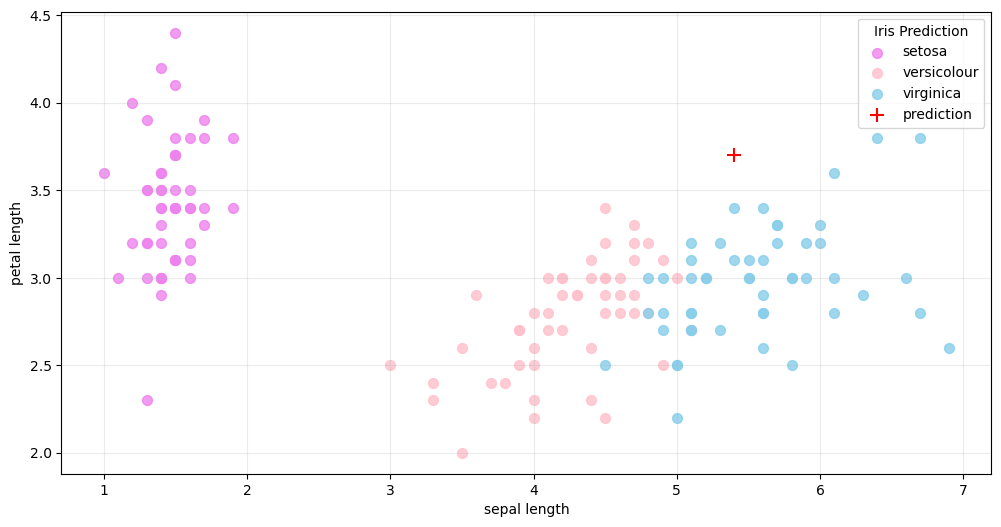

In [145]:
# create a testset
index = random.randrange(0, 50)
test_x, test_y = testset[index]

labels = ["setosa","versicolour","virginica"] # ordinal linear regressor
setosa = np.array([list(trainset.x[_]) for _ in range(trainset.__len__()) if trainset.y[_] == 0])
versicolour = np.array([list(trainset.x[_]) for _ in range(trainset.__len__()) if trainset.y[_] == 1])
virginica = np.array([list(trainset.x[_]) for _ in range(trainset.__len__()) if trainset.y[_] == 2])
pred = model(test_x)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.set_xlabel('sepal length')
ax1.set_ylabel('petal length')
ax1.grid(True, alpha=0.25)

ax1.scatter(x=setosa[:, 2], y=setosa[:, 1], s=50, alpha=0.8, c="violet", label="setosa")
ax1.scatter(x=versicolour[:, 2], y=versicolour[:, 1], s=50, alpha=0.8, c="pink", label="versicolour")
ax1.scatter(x=virginica[:, 2], y=virginica[:, 1], s=50, alpha=0.8, c="skyblue", label="virginica")
ax1.scatter(x=test_x[0], y=test_x[1], s=100, alpha=1, c="r", marker="+", label=f"prediction")
ax1.legend(fontsize="10", loc="best", title="Iris Prediction")

In [146]:
print(f"predicted class: {pred:.2f} actual class: {test_y}")

predicted class: -0.05 actual class: 0
